# Building CNNs for photo classification using PyTorch: How Choice of activation function impacts model accuracy and runtime. 

In this notebook, we build a Convolution Neural Network (CNN) to classify bird species from images using PyTorch. We also investigate how the choice of activation function changes the model results and runtime.

Assumed background: Readers have some basic knowledge of CNNs and ML techniques and have read through ../Q2_CNN/Q2_CNN_Birds.ipynb

In [1]:
# First, this will ensure that your machine has the corrext packages
!pip install -r ../../dependancies.txt

## Introduction

Dataset:
- We will use the Birds classification dataset from Rahma Sleam, Kaggle.
- There are 6 types target classes
    - American Goldfinch
    - Barn Owl
    - Carmine Bee-Eater
    - Downy Woodpecker
    - Emperor Penguin
    - Flamingo
- All these birds have their own distinct features as they range over across a wide range of habitats - see link for more detail.

We Will:
- Load an image dataset
- Explore how the dataset is distributed among each class to allow investigation into any biases if required
- Apply preprocessing and augmentation
- Train a CNN 
- Evaluate its performance
- Loop over various activation functions and compare results. 
    - List of activation functions we will investigate:
        - Relu, Tanh, Leaky_relu and sigmoid

_Link to dataset: https://www.kaggle.com/datasets/rahmasleam/bird-speciees-dataset All rights to their respective owners_

## Importing Libraries
Here, we import the revelent packages from PyTorch, Torchvision and some useful python libraries that will help us to visualise and manipulate data

In [2]:
## Importing Libraries 
## To be updated to be stored in a dependancies folder
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import os

## Device allocation
We leverage faster runtimes on GPU when available. Note that this notebook was set up using CPU. 

In [3]:
## Which device?
print(">>> Device\nGPU Available: ", torch.cuda.is_available())

## Setting Device
if torch.cuda.is_available() == False:
    print("Switching to CPU.... \nMay result in slower performance")
    device = "cpu"
else:
    print("Cuda GPU found, switching device to increase performance")
    device = "cuda"

>>> Device
GPU Available:  False
Switching to CPU.... 
May result in slower performance


## Transforms and augmentation
We apply transforms to normalise and standardise data to allow better model efficiency.
Random horizontal flips and randome rotations are applied across each class to improve model generalisation. Note that the transforms are consistent across each class, as the data is well-distributed

In [4]:
transform = transforms.Compose([
    ## Transforms data when called
    ## Resize: Ensures that all images have same size - needed for batching
    ## Rand Horizontal Flip: Used to augment data
    ## Rand Rotation: Used to augment data
    ## To Tensor: converts to a PyTorch Tensor, needed for processing
        ## (H,W,C) -> (C,H,W)
    ## Normalises data to mean=std=0.5,0.5,0.5 
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])  

## Loading the dataset

To load the dataset, we use torchvision.datasets.ImageFolder which assumes:
- One folder per class
- Images are inside each folder

Then, it is good practice to investigate how the data is distributed among each class. This will help us to determine whether we need to eliminate any biases

In [5]:
data_path = "../../birds_dataset/Bird Speciees Dataset/"

## Loading the total data 
data = torchvision.datasets.ImageFolder(
    ## Loading data usng Image Folder
    ## Root: where the data is stored
    ## Transform: applies the transforms / augmentations we defined earlier
    root = data_path,
    transform = transform,
)

## Investigating distribution
classes = data.classes
print(">>> Investigating distribution")
## Counter counts how may times each bird appears
class_counts = Counter(data.targets)
for index, count in class_counts.items():
    ## Loops through each class index and its image count
    print(f"{data.classes[index]} : {count}")

>>> Investigating distribution
AMERICAN GOLDFINCH : 143
BARN OWL : 129
CARMINE BEE-EATER : 131
DOWNY WOODPECKER : 137
EMPEROR PENGUIN : 139
FLAMINGO : 132


## Train / Test Split

We now will split the dataset into a 80% : 20% split for training and testing
- 80% of the total data will be used to train the model
- 20% of the total data will be used to test the model and produce accuracy scores

This is common practice in ML because:
- It can help to ensure that the CNN is not simply memorising patterns from training. This helps to prevent overfitting:
- Overfitting occurs when the CNN fits the training data too closely, that it cannot provide good predictions on unseen data

Batch size is a training hyperparameter that defines how many samples a neural network processes at once, before updating its weights during training. Here, it is set to 16. 

In PyTorch, data is loaded through something called Dataloaders which do the following:
- Load the data in batches
- Shuffle training data
- Improve perfomance

In [6]:
## Setting batch size to 16
## Model will process 16 images at a time before updating its weights
batch_size = 16
print(">>> Splitting data into 80% training and 20% testing")

## Calculating the training and testing sizes
## Note: test_size best not be deinfed as int(0.2 * len(data)) due to potential rounding error
## random_split: sing PyTorch's built in random splitter
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(
    ## Loading training set
    ## shuffle: randomly shuffles the data during training
    ## num_workers = 0: loads data using main process, no parallel loading (sciserver friendly)
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

test_loader = DataLoader(
    ## Loading testing set
    ## shuffle: keeps data consecutive during testing
    ## num_workers = 0: loads data using main process, no parallel loading (sciserver friendly)
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0
)
print(">>> Complete")

>>> Splitting data into 80% training and 20% testing
>>> Complete


## Visualising data

Its common practice to visualise the data before training a CNN. This has many benefits:
- Ensure the images are loading correctly
- To visualise how the data is being augmentated - useful when troubleshooting ie if the intensity needs to be higher / lower
- To ensure that the images are the same size

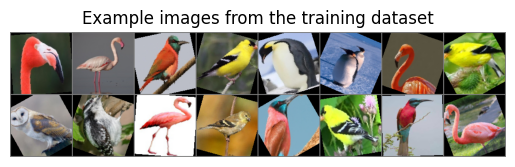

>>> Notice how there are 16 images (defined from the batch_size), and that each time there is a different set of images (as data is shuffled)


In [7]:
def imshow(img):
    ## Helper function to load image
    ## img: Reverses the normalisation applied in the transform 
    ## npimg: Covnerts PyTorch tensor to np.array - readabl by matplotlib
    ## np.transpose: Ensures that the height, width, channels are in correct order
    ## plt.imshow(...): Load image grid
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
    plt.title("Example images from the training dataset")
    plt.show()
    
## Calling helper function and choosing images from first data batch
## dataiter: Converts train_loader to an iterator - allow fetching of batches
## images, labels = next(dataiter: Gets the first batch)
## imshow(...): Calls function above to show images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(">>> Notice how there are 16 images (defined from the batch_size), and that each time there is a different set of images (as data is shuffled)")

## Defining CNN Architecture, training, testing and evaluation

Whilst the notebook in ../Q2_CNN seperates the CNN architecture, training, testing and evalutaion in seperate code blocks, here will will combine them into one as we are iterating over each activation function. 


In [8]:
## List of activation functions to be investigated
activation_functions = [torch.nn.functional.relu, torch.tanh, torch.nn.functional.leaky_relu, torch.sigmoid]

## Where results will be stored
results = []

for activation_fn in activation_functions:
    ## Loops over every activation function (Starts runtime)
    ## Defines CNN Architecture 
    ## Trains network and ends runtime
    ## Tests network and saves results
    print("\n\n>>> Training with activation function: ", activation_fn.__name__)
    start_time = time.time()
    
    ## Defining a CNN
    class Net(nn.Module):
    ## Definition of CNN Architecture
    ## Net(nn.Module) creates a custom CNN from PyTorch
        def __init__(self, num_classes = 6, activation_fn=F.relu):
    ## num_classes = 6: There are 6 types of bird
        ## input_size = 128: Input images been resized to 128
        ## super().__init__(): Initialisation
        ## Definition of convolutional layers
            ## conv1: Input 3 channels (RGB), outputs 6 feature maps, 5x5 kernel
            ## pool: Max pooling: reduces spatial dimensions by taking the maximum value for every 2x2 grid
            ## conv2: Input 6 channels, output 16 channels, 5x5 kernel
        ## Definition of Fully Connected Layers
            ## fc1: 16*29*29 input features (comes from size of feature maps after conv layers), 120 outputs
            ## fc2: 120 inputs, 84 outputs
            ## fc3: 84 inputs, 6 outputs (classes)
        ## Activation function initilised to relu, but will be changed
            
            super().__init__()
            self.activation_fn = activation_fn
            
            ## Conv layers
            self.conv1 = nn.Conv2d(3,6,5)
            self.pool = nn.MaxPool2d(2,2)
            self.conv2 = nn.Conv2d(6,16,5)
        
            ## FN layers
            self.fc1 = nn.Linear(16*29*29, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)
            
        def forward(self, x):
        ## Forward defines how data flows through a network
        ## X goes through:
            ## conv layer 1
            ## conv layer 2
            ## Image gets flattened to a vector for the FC layers
            ## FC Layer 1
            ## FC Layer 2
            ## FC Layer 3 - this is the output layer
            ## conv layers, relu and pooling
            
            x = self.pool(self.activation_fn(self.conv1(x)))
            x = self.pool(self.activation_fn(self.conv2(x)))

            x = torch.flatten(x, 1)

            x = self.activation_fn(self.fc1(x))
            x = self.activation_fn(self.fc2(x))

            x = self.fc3(x)
            return x

    ## Initiate Network
    net = Net(num_classes=6, activation_fn=activation_fn)
    print(net)

    ## Defining cross entropy loss and adam optimiser (See notebook in ../Q2_CNN)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.to(device)



    for epoch in range(10):
    ## Training loop - this is where the model trains on the data
    ## Epoch: How many times teh model goes through the training set
    ## running_loss: tracks the loss
        running_loss = 0.0
    
        for i, (inputs, labels) in enumerate(train_loader):
            ## Loops over training data
            ## inputs = image batch, labels = corresponding classes
            ## inputs.to(device) / labels.to(device) moves the current batch to the device chosen
            ## optimiser.zero_grad() resets the loss gradient
            ## outputs = net(inputs) sends data through CNN
            ## Definition of loss function as defined above
            ## loss.backward(): Computes the loss and finds which neurons contributed most 
            ## optimiser.step(): Adam optimiser updates the model weights 
            ## running_loss(): Tracks the running loss
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
            ## Print loss every 10 batches
            if (i+1) % 10 ==0:
                print(f"Epoch {epoch+1}, Batch {i+1} Loss: {running_loss / 10:.3f}")
                running_loss = 0.0
    ## Ending and calculating runtime
    end_time = time.time()
    runtime = end_time - start_time
    print("Finished Training for ", activation_fn.__name__)

    ## Save the model
    PATH = str("./bird_classifier_"+ activation_fn.__name__+".pth")
    torch.save(net.state_dict(), PATH)
    print(f"\n\n>>> Saved model to ./bird_classifier_{activation_fn.__name__}.pth")

    ## Creating dictionaries that track proedictions
    net.eval()
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    ## Testing model and saving preictions
    print(">>> Testing model")
    with torch.no_grad():
        ## torch.no_grad(): Does not calculate gradient loss which is uncessisary when testing.
        for data in test_loader:
            ## loop through each batch in  the testing dataset
            ## Moves the current batch to the device
            ## outputs = net(images): Sends data through CNN
            ## torch.max: Returns class with highest predicted score for each image
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
        
            for label, prediction in zip(labels, predictions):
                ## If prediction matches the true label, correct_pred increases for that class
                ## Every loop increases total_pred for that class 
                label = label.item()
                prediction = prediction.item()
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            
    for classname, correct_count in correct_pred.items():
        ## Loop over each correct prediction
        ## accuracy: computs the accuracy for each class
        ## Appends this to a dictionary
        ## overall accuracy then computed
        ## Appended to dictionay
        ## Results are then converted to a panda dataframe
        ## Results displayeds
        accuracy = 100 * float(correct_count) / total_pred[classname]
        results.append({
            "Activation Function: ": activation_fn.__name__,
            "Class: ": classname,
            "Accuracy: ": accuracy
        })
        
    overall_correct = sum(correct_pred.values())
    overall_total = sum(total_pred.values())
    overall_accuracy = 100 * float(overall_correct) / overall_total
    results.append({
        "Activation Function: ": activation_fn.__name__,
        "Class: ": "Overall",
        "Accuracy: ": overall_accuracy,
        "Runtime: ": runtime
    })
    
results_df = pd.DataFrame(results)
display(results_df)



>>> Training with activation function:  relu
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)
Epoch 1, Batch 10 Loss: 1.733
Epoch 1, Batch 20 Loss: 1.556
Epoch 1, Batch 30 Loss: 1.436
Epoch 1, Batch 40 Loss: 1.464
Epoch 2, Batch 10 Loss: 1.204
Epoch 2, Batch 20 Loss: 1.101
Epoch 2, Batch 30 Loss: 1.140
Epoch 2, Batch 40 Loss: 0.999
Epoch 3, Batch 10 Loss: 0.928
Epoch 3, Batch 20 Loss: 0.853
Epoch 3, Batch 30 Loss: 0.923
Epoch 3, Batch 40 Loss: 0.851
Epoch 4, Batch 10 Loss: 0.789
Epoch 4, Batch 20 Loss: 0.746
Epoch 4, Batch 30 Loss: 0.774
Epoch 4, Batch 40 Loss: 0.680
Epoch 5, Batch 10 Loss: 0.630
Epoch 5, Batch 20 Loss: 0.571
Epoch 5, Batch 30 

,Activation Function:,Class:,Accuracy:,Runtime:
0,relu,AMERICAN GOLDFINCH,96.153846,NaN
1,relu,BARN OWL,86.666667,NaN
2,relu,CARMINE BEE-EATER,72.000000,NaN
3,relu,DOWNY WOODPECKER,86.363636,NaN
4,relu,EMPEROR PENGUIN,89.285714,NaN
5,relu,FLAMINGO,81.250000,NaN
6,relu,Overall,85.276074,821.296786
7,tanh,AMERICAN GOLDFINCH,96.153846,NaN
8,tanh,BARN OWL,93.333333,NaN
9,tanh,CARMINE BEE-EATER,92.000000,NaN


## Resources used in this Notebook

**Code inspired by**
1. Code heavily inspired by ../Q2_CNN notebook and references listed at the end of that notebook - this code has just been modified to iterate over a list of activation functions.   
